<a href="https://colab.research.google.com/github/Gladiator07/GPU-vs-TPU/blob/main/gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Profiling

## Install dependencies

In [3]:
!pip install -U pip install -U tensorboard_plugin_profile==2.3.0
!pip install wandb

     |████████████████████████████████| 1.6MB 15.5MB/s 
Requirement already up-to-date: install in /usr/local/lib/python3.7/dist-packages (1.3.4)
     |████████████████████████████████| 1.1MB 47.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 1.8 MB 14.1 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 166 kB 56.6 MB/s 
     |████████████████████████████████| 131 kB 40.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6488 sha256=5100d0660c592cb82a996ffdd8d2dbda7687ee7becc1e3bf3e035a8c39575847
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8784 sha256=e3ac4ae603824b3d8a7af56f7a9ae92b7928f897e

In [4]:
!nvidia-smi

Fri May 28 17:15:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [5]:
import math, re, os, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE


from wandb.keras import WandbCallback

import wandb

Tensorflow version 2.5.0


In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

print(strategy)

REPLICAS:  1


In [7]:
GCS_DS_PATH = "gs://kds-1d93f9f432691517cdc18eaca42e621644a47819b3b2b6af7a944868"

## Configuration


In [8]:
IMAGE_SIZE = [512, 512] 
                        
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

## Utils

In [9]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Load data

In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)  # image format uint8 [0,255]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [11]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
Training data label examples: [ 67  48 103 ...  90  63  94]
Validation data shapes:
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
Validation data label examples: [47 36 54 ... 86 89 96]
Test data shapes:
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
(64, 512, 512, 3) (64,)
Test data IDs: ['b9a6f2dab' '26b07058c' 'f563b8f1b' ... 'e78504c82' '132212f11' '19f37512d']


In [12]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

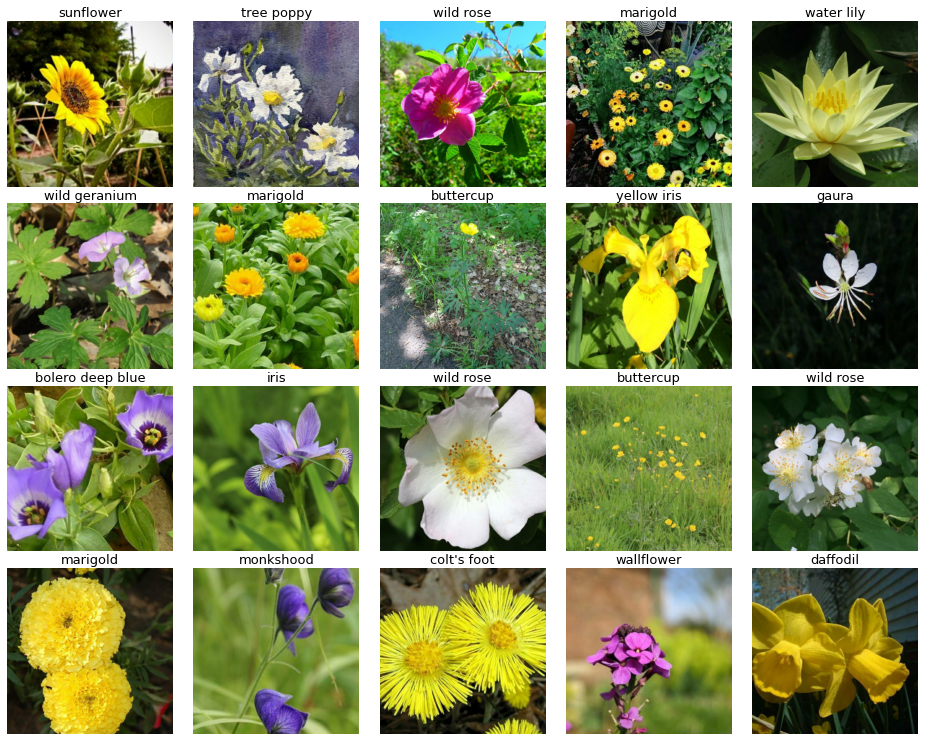

In [13]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

## Build a model on GPU

In [14]:
# from keras.applications.DenseNet201 import preprocess_input

with strategy.scope():
    # img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
    
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.densenet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False)
    
    pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, use_bias=True, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, use_bias=True, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])


        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
    # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
    steps_per_execution=16
)
model.summary()

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

74842112/74836368 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1967104   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________

Learning rate per epoch:


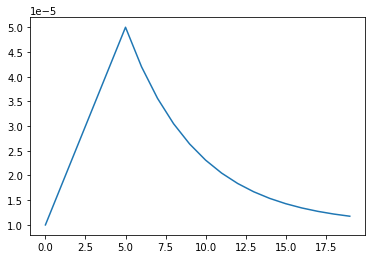

In [15]:
EPOCHS = 20

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [16]:
# # Get TPU profiling service address. This address will be needed for capturing
# # profile information with TensorBoard in the following steps.
# service_addr = tpu.get_master().replace(':8470', ':8466')
# print(service_addr)

In [17]:
# Initiate wandb
run = wandb.init(project="GPU-vs-TPU")


# log params to wandb
config = wandb.config
config.start_lr = start_lr
config.min_lr = min_lr
config.max_lr = max_lr
config.exp_decay = exp_decay
config.num_of_epochs = EPOCHS
config.image_size = IMAGE_SIZE
config.batch_size = BATCH_SIZE
config.model_summary = short_model_summary

start_time = time.time()
# # Start training
# history = model.fit(get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
#                     validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS, callbacks=[lr_callback, WandbCallback()])

end_time = time.time() - start_time
print(f"Ended in {end_time}")

# log time taken to wandb
wandb.log({"Time_taken":end_time})

wandb.finish()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Ended in 5.173683166503906e-05


Time_taken,5e-05
_runtime,3
_timestamp,1622222213
_step,0


Time_taken,▁
_runtime,▁
_timestamp,▁
_step,▁
